In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/AML/

/content/drive/MyDrive/AML


In [ ]:
%ls


AML_blackbox.ipynb                                Test_data.csv           Train_data.csv
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  Test_data_with_adv.csv  Train_data_with_adv.csv


In [ ]:
!pip install textattack

In [ ]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from textattack.attack_recipes import A2TYoo2021
from textattack import Attacker, AttackArgs
from textattack.models.wrappers import SklearnModelWrapper
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('Train_data.csv', header=None, low_memory=False)
df.columns = df.iloc[0]
df = df[1:]
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
1,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0,0,0,0.05,0,normal
2,0,udp,other,SF,146,0,0,0,0,0,...,1,0,0.6,0.88,0,0,0,0,0,normal
3,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.1,0.05,0,0,1,1,0,0,anomaly
4,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1,0,0.03,0.04,0.03,0.01,0,0.01,normal
5,0,tcp,http,SF,199,420,0,0,0,0,...,255,1,0,0,0,0,0,0,0,normal


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to categorical columns
df['protocol_type'] = le.fit_transform(df['protocol_type'])
df['service'] = le.fit_transform(df['service'])
df['flag'] = le.fit_transform(df['flag'])
df['class'] = le.fit_transform(df['class'])

# Display the updated DataFrame
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
1,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0,0,0,0.05,0,1
2,0,2,41,9,146,0,0,0,0,0,...,1,0,0.6,0.88,0,0,0,0,0,1
3,0,1,46,5,0,0,0,0,0,0,...,26,0.1,0.05,0,0,1,1,0,0,0
4,0,1,22,9,232,8153,0,0,0,0,...,255,1,0,0.03,0.04,0.03,0.01,0,0.01,1
5,0,1,22,9,199,420,0,0,0,0,...,255,1,0,0,0,0,0,0,0,1


In [ ]:
# Separate features and target
X = df.drop('class', axis=1)
y = df['class'].apply(lambda x: 1 if x == 'normal.' else 0)

# Check for class imbalance
print(y.value_counts())

# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check for class imbalance in training set
print(y_train.value_counts())



class
0    25192
Name: count, dtype: int64
class
0    17634
Name: count, dtype: int64


In [ ]:
# Train the  RandomForest model
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7558

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558



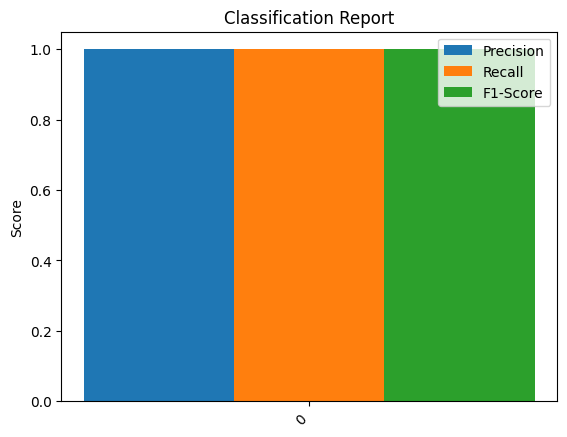

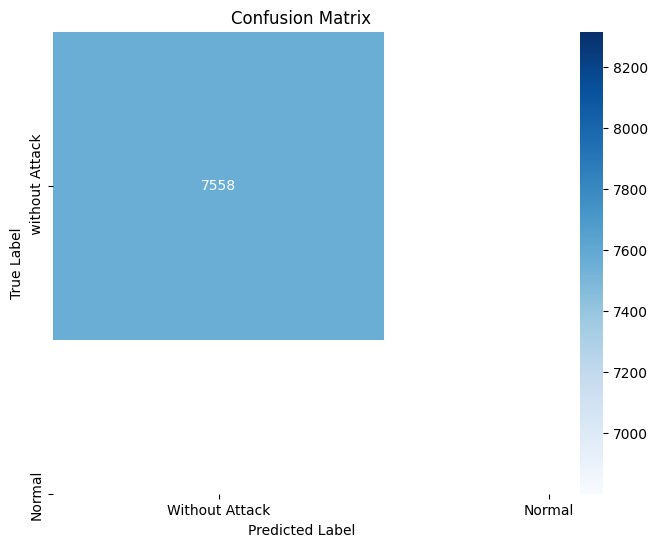

In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Extract precision, recall, and f1-score for each class
classes = list(report.keys())[:-3]  # Exclude 'accuracy' and 'macro avg'
precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1_score = [report[cls]['f1-score'] for cls in classes]

# Create a bar plot
x = range(len(classes))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x, precision, width, label='Precision')
rects2 = ax.bar([i + width for i in x], recall, width, label='Recall')
rects3 = ax.bar([i + width * 2 for i in x], f1_score, width, label='F1-Score')

# Add labels and title
ax.set_ylabel('Score')
ax.set_title('Classification Report')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.legend()

# Display the plot
plt.show()

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Without Attack', 'Normal'], yticklabels=[' without Attack', 'Normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Advesarial Atack using Gentic Algorithm

In [ ]:
# Parameters for the genetic algorithm
population_size = 50
num_generations = 20
mutation_rate = 0.1
num_parents = 20

# Initialize a random population of adversarial examples
def initialize_population(X, size):
    sampled_indices = np.random.choice(X.index, size, replace=False)
    sampled_population = X.loc[sampled_indices].values
    perturbations = np.random.normal(0, 0.1, (size, X.shape[1]))
    return sampled_population + perturbations

# Fitness function to evaluate how well an adversarial example fools the model
def fitness_function(X_adv, model, y_true):
    predictions = model.predict(X_adv)
    return np.sum(predictions != y_true)

# Crossover function
def crossover(parent1, parent2):
    return (parent1 + parent2) / 2

# Mutation function
def mutate(individual):
    return individual + np.random.normal(0, 0.1, individual.shape)

# Genetic Algorithm
def adversarial_genetic_algorithm(X_train, y_train, population_size, num_generations, mutation_rate):
    # Initialize population
    population = initialize_population(X_train, population_size)

    for generation in range(num_generations):
        fitness_scores = np.array([fitness_function(individual.reshape(1, -1), model, y_train) for individual in population])

        # Select the best individuals
        parents_indices = np.argsort(fitness_scores)[:num_parents]
        parents = population[parents_indices]

        # Create offspring through crossover
        offspring = []
        for i in range(population_size - num_parents):
            parent1, parent2 = parents[np.random.choice(num_parents, 2, replace=False)]
            child = crossover(parent1, parent2)
            if np.random.rand() < mutation_rate:
                child = mutate(child)
            offspring.append(child)

        # Create the new population
        population = np.vstack((parents, offspring))

        # Log progress
        print(f"Generation {generation + 1}: Best fitness = {np.min(fitness_scores)}")

    return population

In [ ]:
df = pd.read_csv('Train_data.csv')
# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to categorical columns
df['protocol_type'] = le.fit_transform(df['protocol_type'])
df['service'] = le.fit_transform(df['service'])
df['flag'] = le.fit_transform(df['flag'])
df['class'] = le.fit_transform(df['class'])

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

df.head()



,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [ ]:

# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[3504   12]
 [   6 4036]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3516
           1       1.00      1.00      1.00      4042

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558



In [ ]:
# Run the genetic algorithm
adversarial_population = adversarial_genetic_algorithm(X_train, y_train.values, population_size, num_generations, mutation_rate)

# Generate corresponding labels for adversarial examples
original_samples_indices = np.random.choice(X_train.index, size=population_size, replace=False)
y_adv_labels = y_train.loc[original_samples_indices].values

# Create adv_train_data (assuming adversarial_population is a NumPy array)
adv_train_data = pd.DataFrame(adversarial_population, columns=X_train.columns, index=original_samples_indices)
# Evaluate on the original test set
y_pred = model.predict(X_test)
print("Evaluation on Original Test Set:")
print(classification_report(y_test, y_pred))

# Evaluate on adversarial examples using their corresponding labels
y_pred_adv = model.predict(adversarial_population)
print("\nEvaluation on Adversarial Examples:")
print(classification_report(y_adv_labels, y_pred_adv))

Generation 1: Best fitness = 8227
Generation 2: Best fitness = 8227
Generation 3: Best fitness = 8227
Generation 4: Best fitness = 8227
Generation 5: Best fitness = 8227
Generation 6: Best fitness = 8227
Generation 7: Best fitness = 8227
Generation 8: Best fitness = 8227
Generation 9: Best fitness = 8227
Generation 10: Best fitness = 8227
Generation 11: Best fitness = 8227
Generation 12: Best fitness = 8227
Generation 13: Best fitness = 8227
Generation 14: Best fitness = 8227
Generation 15: Best fitness = 8227
Generation 16: Best fitness = 8227
Generation 17: Best fitness = 8227
Generation 18: Best fitness = 8227
Generation 19: Best fitness = 8227
Generation 20: Best fitness = 8227
Evaluation on Original Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3516
           1       1.00      1.00      1.00      4042

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weig

In [ ]:
original_rows = len(df)
modified_rows = len(adv_train_data)
percentage_modified = (modified_rows / original_rows) * 100

print(f"Percentage of records modified: {percentage_modified:.2f}%")

# Calculate the percentage of modification for each attribute
modification_percentages = {}
for column in df.columns:
  if column != 'class':
    # Select only the rows that have been modified
    original_values = df.loc[adv_train_data.index, column].values
    modified_values = adv_train_data[column].values
    num_modified = np.sum(original_values != modified_values)
    percentage_modified_column = (num_modified / modified_rows) * 100
    modification_percentages[column] = percentage_modified_column

# Print the attributes affected with modification percentage
print("Attributes affected by adversarial attack with modification percentage:")
for attribute, percentage in modification_percentages.items():
  if attribute not in ['protocol_type', 'flag']:
    print(f"{attribute}: {percentage:.2f}%")

Percentage of records modified: 0.20%
Attributes affected by adversarial attack with modification percentage:
duration: 100.00%
service: 100.00%
src_bytes: 100.00%
dst_bytes: 100.00%
land: 100.00%
wrong_fragment: 100.00%
urgent: 100.00%
hot: 100.00%
num_failed_logins: 100.00%
logged_in: 100.00%
num_compromised: 100.00%
root_shell: 100.00%
su_attempted: 100.00%
num_root: 100.00%
num_file_creations: 100.00%
num_shells: 100.00%
num_access_files: 100.00%
num_outbound_cmds: 100.00%
is_host_login: 100.00%
is_guest_login: 100.00%
count: 100.00%
srv_count: 100.00%
serror_rate: 100.00%
srv_serror_rate: 100.00%
rerror_rate: 100.00%
srv_rerror_rate: 100.00%
same_srv_rate: 100.00%
diff_srv_rate: 100.00%
srv_diff_host_rate: 100.00%
dst_host_count: 100.00%
dst_host_srv_count: 100.00%
dst_host_same_srv_rate: 100.00%
dst_host_diff_srv_rate: 100.00%
dst_host_same_src_port_rate: 100.00%
dst_host_srv_diff_host_rate: 100.00%
dst_host_serror_rate: 100.00%
dst_host_srv_serror_rate: 100.00%
dst_host_rerror_r

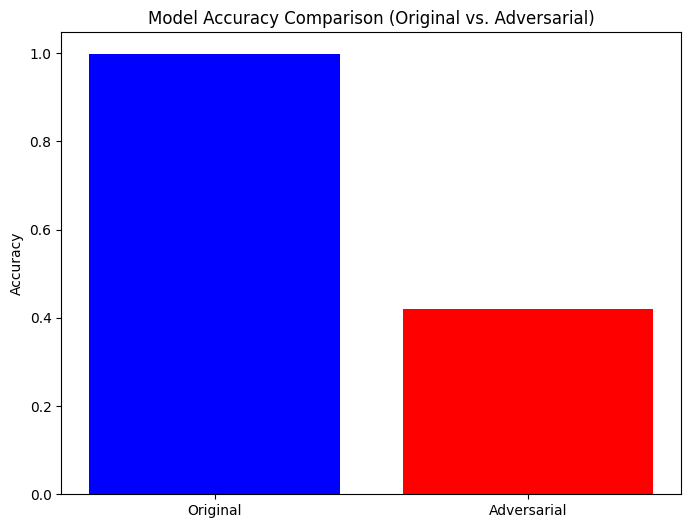

In [ ]:
# Calculate accuracy for both original and adversarial datasets
original_accuracy = accuracy_score(y_test, y_pred)
adversarial_accuracy = accuracy_score(y_adv_labels, y_pred_adv)

# Create a bar plot to compare accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Original', 'Adversarial'], [original_accuracy, adversarial_accuracy], color=['blue', 'red'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (Original vs. Adversarial)')
plt.show()

when you alter modification it should make scence

### simulate adversarial perturbations using Gaussian

In [ ]:
# added perturbation taking reference from https://engineering.purdue.edu/ChanGroup/ECE595/files/chapter3.pdf
# Get the column indices to perturb instead of names
columns_to_perturb_indices = [list(X.columns).index(col) for col in X.columns if col not in ['protocol_type', 'flag', 'land', 'hot', 'root_shell', 'num_outbound_cmds']]

def add_perturbations(X, epsilon=0.1, columns_to_perturb=columns_to_perturb_indices):
    """
    Add random noise to simulate adversarial perturbations.
    :param X: Original feature matrix
    :param epsilon: Perturbation magnitude
    :param columns_to_perturb: List of column *indices* to apply perturbations to.
    :return: Perturbed feature matrix
    """
    X_adv = X.copy()
    for column_index in columns_to_perturb:
        # Create a new column with random noise
            perturbation = np.random.uniform(-epsilon, epsilon, X.shape[0])
            X_adv.iloc[:, column_index] = X_adv.iloc[:, column_index] + perturbation
    return X_adv

In [ ]:
# Convert X_train and X_test to numeric dtype
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with 0 (You can choose a different strategy if needed)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [ ]:
# Apply perturbations to the training and test sets
X_train_adv = add_perturbations(X_train)
X_test_adv = add_perturbations(X_test)

In [ ]:
# Create DataFrame for adversarial examples
adv_train_data = pd.DataFrame(X_train_adv, columns=X.columns)
adv_train_data['class'] = y_train.values

adv_test_data = pd.DataFrame(X_test_adv, columns=X.columns)
adv_test_data['class'] = y_test.values

# Save the modified datasets
adv_train_data.to_csv('Train_data_with_adv.csv', index=False)
adv_test_data.to_csv('Test_data_with_adv.csv', index=False)


In [ ]:
# Load the modified datasets
adv_train_data = pd.read_csv('/content/drive/MyDrive/AML/Train_data_with_adv.csv')
adv_test_data = pd.read_csv('/content/drive/MyDrive/AML/Test_data_with_adv.csv')


#printing modified data to verify
adv_train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,-0.007484,1,45.990571,5,0.033821,-0.038108,0,0.080045,0.070085,0,...,1.095398,0.015003,0.047005,-0.088119,-0.064199,0.966022,0.917466,0.015401,0.069390,0
1,-0.035807,1,15.917484,2,-0.002238,0.056008,0,0.092694,0.009088,0,...,4.084229,0.038618,0.005223,-0.022586,-0.019101,-0.067726,-0.049094,0.972453,0.951913,0
2,0.038788,1,2.963656,1,0.085232,0.081275,0,-0.068399,0.009066,0,...,14.040894,0.134181,-0.002529,0.034435,0.067788,-0.020717,0.077064,0.990649,0.911699,0
3,0.096630,0,12.917675,9,7.947823,0.086387,0,-0.093389,-0.066360,0,...,151.942336,0.998786,0.021026,0.992040,0.480481,-0.003789,-0.098701,-0.058811,-0.052734,0
4,0.024630,1,46.084724,5,0.074832,-0.028987,0,0.019277,0.012841,0,...,8.976544,0.095733,0.020218,0.109066,-0.032429,1.066678,0.922366,0.028686,-0.012378,0


In [ ]:
# Separate features and target for the modified datasets
X_train_adv = adv_train_data.drop('class', axis=1)
y_train_adv = adv_train_data['class']
X_test_adv = adv_test_data.drop('class', axis=1)
y_test_adv = adv_test_data['class']

# Train the RandomForest model on the modified dataset
clf_adv = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf_adv.fit(X_train_adv, y_train_adv)

# Evaluate the model on the modified dataset
y_pred_adv = clf_adv.predict(X_test_adv)
print("Accuracy (Adversarial):", accuracy_score(y_test_adv, y_pred_adv))
print("Classification Report (Adversarial):\n", classification_report(y_test_adv, y_pred_adv))

Accuracy (Adversarial): 0.9966922466260916
Classification Report (Adversarial):
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      3516
           1       1.00      1.00      1.00      4042

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558



In [ ]:
# Calculate the percentage of modified records
original_rows = len(df)
modified_rows = len(adv_train_data) + len(adv_test_data)
percentage_modified = (modified_rows / original_rows) * 100

print(f" Percentage of records modified: {percentage_modified:.2f}%")
# Get the list of columns affected by the adversarial perturbations
affected_columns = [col for col in X.columns if col not in ['protocol_type', 'flag']]

# Print the list of affected columns
print("The following attributes or columns are affected by adversarial perturbations:")
print(affected_columns)

 Percentage of records modified: 100.00%
The following attributes or columns are affected by adversarial perturbations:
['duration', 'service', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


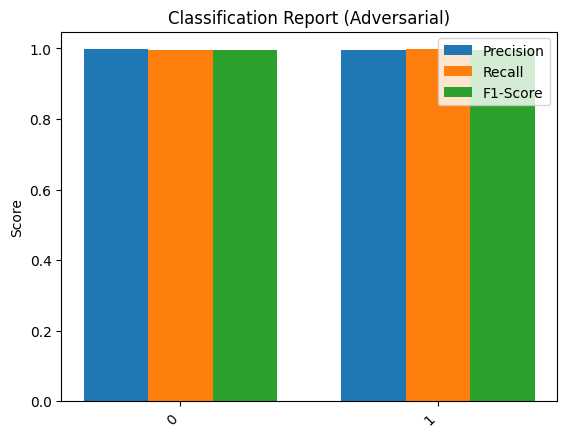

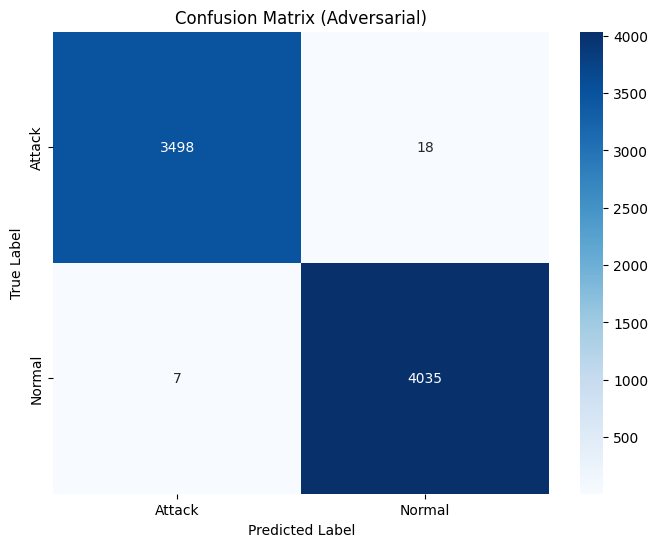

In [ ]:
# Generate classification report for adversarial data
report_adv = classification_report(y_test_adv, y_pred_adv, output_dict=True)

# Extract precision, recall, and f1-score for each class
classes_adv = list(report_adv.keys())[:-3]  # Exclude 'accuracy' and 'macro avg'
precision_adv = [report_adv[cls]['precision'] for cls in classes_adv]
recall_adv = [report_adv[cls]['recall'] for cls in classes_adv]
f1_score_adv = [report_adv[cls]['f1-score'] for cls in classes_adv]

# Create a bar plot for adversarial data
x_adv = range(len(classes_adv))
width_adv = 0.25

fig_adv, ax_adv = plt.subplots()
rects1_adv = ax_adv.bar(x_adv, precision_adv, width_adv, label='Precision')
rects2_adv = ax_adv.bar([i + width_adv for i in x_adv], recall_adv, width_adv, label='Recall')
rects3_adv = ax_adv.bar([i + width_adv * 2 for i in x_adv], f1_score_adv, width_adv, label='F1-Score')

# Add labels and title for adversarial data
ax_adv.set_ylabel('Score')
ax_adv.set_title('Classification Report (Adversarial)')
ax_adv.set_xticks([i + width_adv for i in x_adv])
ax_adv.set_xticklabels(classes_adv, rotation=45, ha="right")
ax_adv.legend()

# Display the plot for adversarial data
plt.show()

# Generate the confusion matrix for adversarial data
cm_adv = confusion_matrix(y_test_adv, y_pred_adv)

# Plot the confusion matrix for adversarial data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adv, annot=True, fmt="d", cmap="Blues", xticklabels=['Attack', 'Normal'], yticklabels=['Attack', 'Normal'])
plt.title('Confusion Matrix (Adversarial)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()